# Identifying Odd Births and Deaths
Tim Tyree <br>
May 26, 2020

### initialize/load the data

In [236]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
from pylab import imshow, show
import skimage as sk
from skimage import measure, filters
from PIL import Image
import imageio
import seaborn as sns
from ast import literal_eval

from lib.minimal_model import *
from lib.TexturePlot import *
from lib.get_tips import *
from lib.minimal_model import *
from lib.intersection import *
from lib.ProgressBar import *
from lib.operari import *
from lib.OddBirthDeathPlots import *

#TODO: use cuda via numba
# from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
# from lib.contours_to_tips import *

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()


%autocall 1
%load_ext autoreload
%autoreload 2

# def save_fun(descrip,ext='.png'):
#     return f'Figures/odd/odd_births_deaths_{descrip}{ext}'

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The struggle of ironing out odd spiral tips

### __Goals__
1. quantify number of births/death numbers that are odd integers
2. select those odd births/deaths
3. find out what they have in common?

__Simulation Workflow__ - save buffers when odd birth/death occur.  They no longer occur<br>
- Done: add function that compares previous to current birth-death rate and checks for a certain change
- Done: save buffer every time an odd birth/death occurs

## Completed: make measures for how often odd births/deaths occur

In [10]:
# data_dir = 'Data/tip_logs_odd_runs/tip_log_circle6_at_time_3012.8.csv' # 2 tips in uniform circular motion
# data_dir = 'Data/tip_logs_odd_runs/tip_log_circle6_params_changed_at_time_1800.0.csv' # chaos - sigma = 1, threshold = 0.9, no wrapping
# data_dir = 'Data/tip_logs_odd_runs/tip_log_chaos_circle6_sigma_2_at_time_3600.2.csv'  # chaos - sigma = 2, threshold = 0.9, no wrapping
# data_dir = 'Data/tip_logs_odd_runs/tip_log_chaos_circle6_sigma_2_wrapping_at_time_1800.0.csv'
# data_dir = 'Data/tip_logs_odd_runs/tip_log_chaos_circle6_sigma_3_threshold_0.8_wrapping_true_at_time_1800.0.csv'
# data_dir = 'Data/tip_logs_odd_runs/tip_log_chaos_circle6_sigma_4_threshold_0.9_wrapping_true_at_time_1800.0.csv'
# descrip = data_dir.replace('Data/tip_log_chaos_circle6_','')[:-4]
# descrip = 'sigma_3_threshold_0.8_yes_wrapping'

data_dir = 'Data/zero_odd_tips_detected_ds_5_param_set_8.csv'
df = pd.read_csv(data_dir)
df.head()

,n,s1,s2,t,x,y
0,48,"(3,)","(1,)",0.002,127.385450,196.908083
1,48,"(3,)","(1,)",0.002,88.983856,146.186622
2,48,"(9,)","(17,)",0.002,72.113406,31.062414
3,48,"(13,)","(17,)",0.002,88.529995,9.381733
4,48,"(13,)","(17,)",0.002,76.504990,589.540427


In [8]:
# # data_dir.replace('Data/tip_log_chaos_circle6_','')[:-4]

# import os

# def find_files(filename, search_path):
#    result = []

# # Wlaking top-down from the root
#    for root, dir, files in os.walk(search_path):
#       if filename in files:
#          result.append(os.path.join(root, filename))
#    return result

# print(find_files("smpl.htm","D:"))




In [15]:
# #compute the number of spiral tips
# t_values = []
# n_values = []
# for j in range(df.t.size):
#     t = df.iloc[j].t
#     t_values.append(t)
#     x = df.iloc[j].x
#     n = x.count('.')#.replace('[','').replace(']','').count('.')
#     n_values.append(n)
# df['n'] = n_values
# df['dn'] = df['n'].diff()
# df = df.dropna().astype({'dn': 'int32'}).copy()

# #check a tautology given the above
# # assert(df[boo_odd].tail(1).x.values[0].count('.') == df[boo_odd].tail(1).n.values[0])

In [17]:
#find/select the birth/deaths values that are odd
dn_values = np.diff(np.array(n_values))
set_bd = list(set(dn_values))
boo = [dn % 2 == 1 for dn in set_bd]
set_odd = np.array(set_bd)[boo]  # the set of all odd birth/death types
boo_odd = df.t.isnull().values
for odd in set_odd:
    boo_odd |= (df.dn == odd)

#a time series of when/where nontrivial birth/deaths occur
series_bd = df.loc[df.dn != 0].dropna().dn
num_odds = len(df[boo_odd].t.values)
num_total = len(series_bd.values)

#bluf - fraction of odd births/deaths
print(f"> odd birthdeaths occured with # of births/deaths per event = {set_odd}.<br>")
print(f"> total # of odd birth/death events detected {num_odds}.<br>")
print(f"> total # of birth/death events detected {num_total}.<br>")
print(f"> the percent of birth/deaths that were odd was {100*num_odds/num_total:.1f}%.<br>")

#bluf - stability of odd spiral tip numbers
print('')
print(f"> # of frames with an odd # of spiral tips created/destroyed = {sum(df.dn%2!=0)}<br>")
print(f"> # of frames with an odd # of spiral tips existing = {sum(df.n%2!=0)}<br>")
print(f"> fraction of such frames that are odd births/deaths = {sum(df.dn%2!=0)/sum(df.n%2!=0):.4f}<br>")

AxisError: axis -1 is out of bounds for array of dimension 0

__Results for chaotic data runs__
1. for data_dir = 'Data/tip_log_circle6_params_changed_at_time_1800.0.csv'
    - sigma = 1, threshold = 0.9, no blur wrapping
    -   >odd birthdeaths occured with [ 1  3 -9 -7 -1 -3] # of births/deaths.<br>
        >total # of odd birth/death events detected 72.<br>
        >total # of birth/death events detected 641.<br>
        >the percent of birth/deaths that were odd was 11.2%.<br>
1. for data_dir = 'Data/tip_log_chaos_circle6_sigma_2_at_time_3600.2.csv' 
    - sigma = 2, threshold = 0.9, no blur wrapping
    -   >odd birthdeaths occured with [ 1 -1] # of births/deaths.<br>
        >total # of odd birth/death events detected 43.<br>
        >total # of birth/death events detected 143.<br>
        >the percent of birth/deaths that were odd was 33.6%.<br>
1. for data_dir = 'Data/tip_log_chaos_circle6_sigma_2_at_time_3600.2.csv' 
    - sigma = 2, threshold = 0.9, blur wrapping in use
    -    >odd birthdeaths occured with # of births/deaths per event = [ 1 -1].<br>
        >total # of odd birth/death events detected 18.<br>
        >total # of birth/death events detected 113.<br>
        >the percent of birth/deaths that were odd was 15.9%.<br>
1. data_dir = 'Data/tip_log_chaos_circle6_sigma_3_threshold_0.8_wrapping_true_at_time_1800.0.csv'
    - > odd birthdeaths occured with # of births/deaths per event = [ 1 -1].<br>
    > total # of odd birth/death events detected 22.<br>
    > total # of birth/death events detected 102.<br>
    > the percent of birth/deaths that were odd was 21.6%.<br>
1. data_dir = 'Data/tip_log_chaos_circle6_sigma_4_threshold_0.9_wrapping_true_at_time_1800.0.csv'
    - > odd birthdeaths occured with # of births/deaths per event = [ 1 -1].<br>
    > total # of odd birth/death events detected 20.<br>
    > total # of birth/death events detected 542.<br>
    > the percent of birth/deaths that were odd was 3.7%.<br>

## Histogram and temporal occurance of odd births/deaths 

In [16]:
# discriminate odd births from odd deaths
todd_values, nodd_values = df[boo_odd][['t','n']].values.T
todd_b_values, nodd_b_values = df[(df.dn>0) & boo_odd][['t','n']].values.T
todd_d_values, nodd_d_values = df[(df.dn<0) & boo_odd][['t','n']].values.T

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

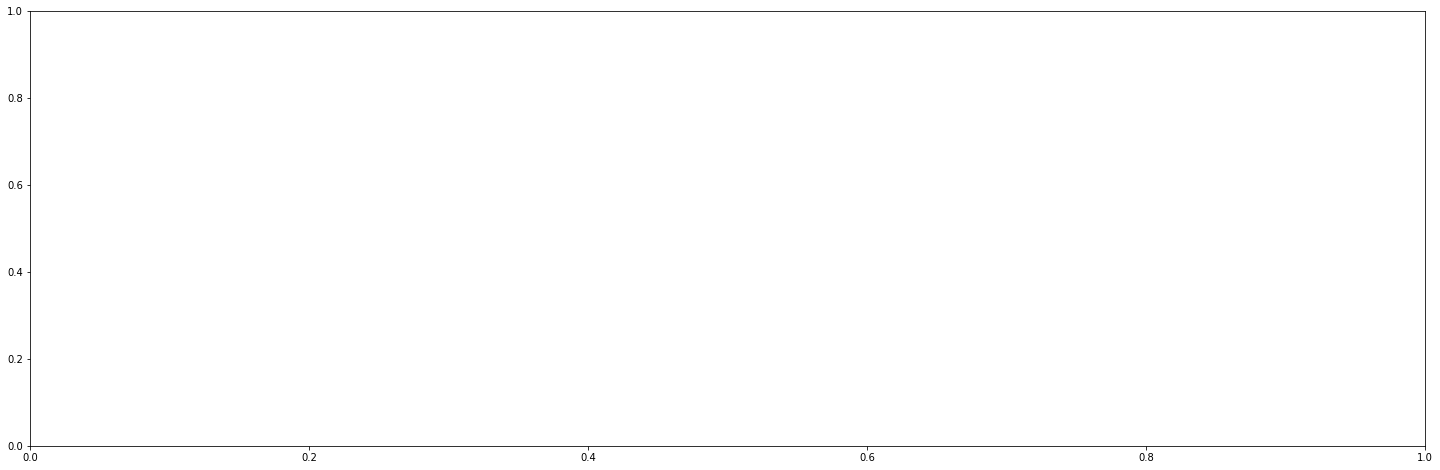

In [6]:

#plot
fig, ax = plt.subplots(figsize=(25,8))
fontsize = 24
# ax.scatter(x=t_values, y=n_values, c='g', alpha=0.7, s=3)
ax.plot(t_values, n_values, c='g', alpha=0.8, lw=2)
ax.scatter(x=todd_b_values, y=nodd_b_values, label=f"odd births", c='b', s=100)
ax.scatter(x=todd_d_values, y=nodd_d_values, label=f"odd deaths", c='r', s=100)
ax.legend(fontsize=fontsize-5)
ax.set_xlabel('time', fontsize=fontsize)
ax.set_ylabel('number of spiral tips', fontsize=fontsize)
ax.tick_params(axis='both', labelsize= fontsize)

plt.tight_layout()
# plt.show()
plt.savefig(save_fun(descrip='odd_timeseries',ext='.svg'))
plt.savefig(save_fun(descrip='odd_timeseries',ext='.png'))

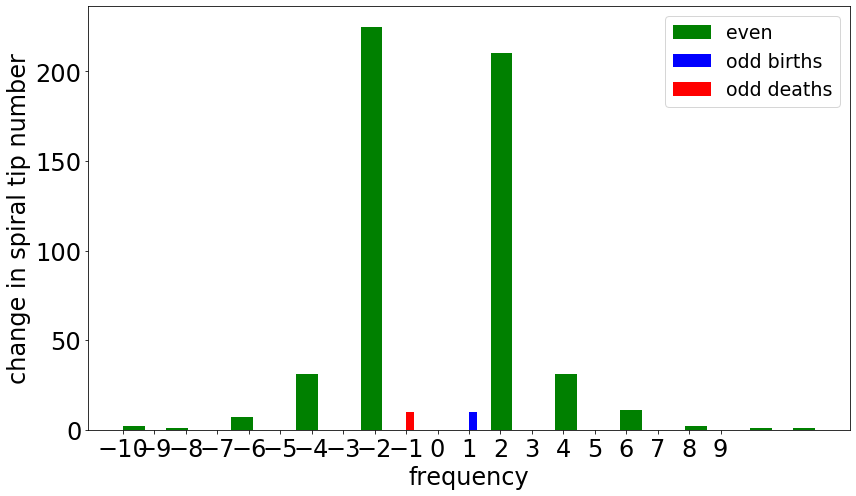

In [18]:
fig, ax = plt.subplots(figsize=(12,7))
# ax.hist(series_bd.values, bins = 50, color='g')
ax.hist(df.loc[(~boo_odd) & (df.dn!=0)].dropna().dn, bins = 32, color='g', label='even')
ax.hist(df.loc[(df.dn>0) & boo_odd].dropna().dn, bins = 4, color='b', label='odd births')
ax.hist(df.loc[(df.dn<0) & boo_odd].dropna().dn, bins = 4, color='r', label='odd deaths')

ax.legend(fontsize=fontsize-5)
ax.set_xticks(list(range(-10,10,1)))
ax.tick_params(axis='both', labelsize= fontsize)
ax.set_xlabel('frequency', fontsize=fontsize)
ax.set_ylabel('change in spiral tip number', fontsize=fontsize)
plt.tight_layout()
plt.tight_layout()
# plt.show()
plt.savefig(save_fun(descrip='odd_histogram',ext='.svg'))
plt.savefig(save_fun(descrip='odd_histogram',ext='.png'))

In [9]:
df.groupby('dn').describe()['n','count']

dn
-10        2.0
-8         1.0
-6         7.0
-4        31.0
-2       225.0
-1        10.0
 0     17457.0
 1        10.0
 2       210.0
 4        31.0
 6        11.0
 8         2.0
 10        1.0
 12        1.0
Name: (n, count), dtype: float64

## Look for commonalities between odd birth/death events


- when did they occur?
    - do odd births come before odd deaths?  
        - Not really, based on visual inspection of the figure.  It looks like births come before deaths about as often as deaths come before births.  Is there useful information stored in s? If not, record total tip number instead.  Maybe there is, though.  s Tells us if higher order births/deaths are on separate contours, which could tell us if we have a higher order interaction (that conserves vorticity) or if we have tree level events that only coincidentally occur at the same time.
            - I observed an x coordinate sublist with 4 entries together with a dn value of 4, which supports the birth of quadrupulets.  This occurred once in the set of 113 events over the period of tmax = 1800.0.  I think rather than 4 tips being created from a point, it is more likely that 2 births occurred ~simultaneously on the intersection of the same two contours.

        - __TODO__: get xy positions for each tip pair and compare between frames.  use this between frames to identify odd events
- can the topological number variable be used to identify and filter them?
    - naïvely, no.  they are not reliably consistent between frames.  
- do they occur near the buffer edges?
- do they persist?
    - not really, no.  this suggests the error lies in the detection and not the simulation


## the recorded nested lists of topological number is not self consistent over time.  This may change with contour finding that obeys periodic boundary conditions 

In [40]:
#as of writing this, the following sublist has 4 entries, that together with dn==4 supports the birth of quadrupulets
# print(df[df.dn==4].x.values)
# print(df[df.dn==4].y.values)

Text(0, 0.5, 'frequency')

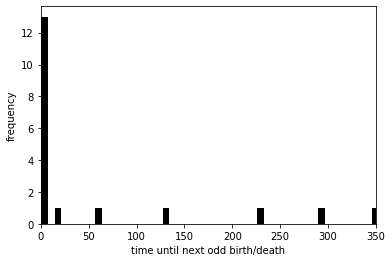

In [11]:
#the amount of time between odd events suggests most are from misclassification, not simulation error
plt.hist(df[boo_odd].t.diff().dropna(), bins=50, color='black')
plt.xlim([0,350])
plt.xlabel('time until next odd birth/death')
plt.ylabel('frequency')

In [39]:
#compute topological numbers from prev/next frame
df['s_prev'] = df.shift(1).s # current val sees previous val here
df['s_next'] = df.shift(-1).s

df = df.dropna().copy()

# can the topological number variable be used to identify and filter them?
s_prev, s_curr, s_next = df[boo_odd][['s_prev','s','s_next']].head(1).values.T
r_prev = set(literal_eval(s_prev[0][1:-1]))
r_curr = set(literal_eval(s_curr[0][1:-1]))
r_next = set(literal_eval(s_next[0][1:-1]))
# r_curr.difference_update(r_prev)
# r_curr.difference_update(r_next)
print(r_prev)
print(r_curr)
print(r_next)


In [14]:
df.iloc[6620:6632].s

6622    ((5, 7), (6, 6))
6623    ((5, 7), (6, 6))
6624    ((5, 7), (6, 6))
6625    ((5, 6), (6, 7))
6626    ((5, 6), (6, 7))
6627    ((5, 6), (6, 7))
6628    ((5, 6), (6, 7))
6629    ((5, 6), (6, 7))
6630    ((5, 6), (6, 7))
6631    ((5, 6), (6, 7))
6632    ((5, 7), (6, 6))
6633    ((5, 7), (6, 6))
Name: s, dtype: object

The contour numbering is not consistent:
>6624    [(3, 6), (4, 7), (5, 4), (6, 5)]

>6625    [(3, 6), (4, 7), (5, 4), (6, 5)]

>6626    [(3, 6), (4, 7), (5, 4), (6, 5)]

>6627    [(3, 6), (4, 7), (5, 4), (6, 5)]

>6628    [(3, 6), (4, 7), (5, 4), (6, 5)]

>6629    [(3, 6), (4, 7), (5, 4), (6, 5)]

>6630    [(3, 6), (4, 7), (5, 4), (6, 5)]

>6631    [(3, 6), (4, 7), (5, 4), (6, 5)]

>6632    [(3, 7), (4, 8), (5, 6), (6, 5)]

>6633            [(3, 7), (5, 6), (6, 5)]

>6634            [(3, 7), (5, 6), (6, 5)]

>6635            [(3, 7), (5, 5), (6, 6)]

## TODO(later): topologically compute spiral tip trajectories
- to identify odd events
- note: this requires contours that obey periodic boundary conditions, which is not implemented as of my writing this

In [15]:
# TODO: get xy positions for each tip pair and compare between frames.  
# (then)TODO: use ^this between frames to identify odd events

    

In [16]:
# first - list of pairs of x coordinates. # second - list of pairs of y coordinates.
d = df.tail()
loc_lst = list(zip(literal_eval(d.x.values[0]),literal_eval(d.y.values[0])))
tipt = d.t.values

In [17]:
loc_lst

[([206.27309076070816, 212.0543074637748],
  [87.5887233580352, 142.21668067858485]),
 ([213.93306864429582, 213.24018432471266],
  [364.86460270126776, 424.9019116180587])]

In [18]:
r = literal_eval(df.tail().x.values[0])

In [19]:
print(f"# of frames with an odd # of spiral tips created/destroyed = {sum(df.dn%2!=0)}")
print(f"# of frames with an odd # of spiral tips existing = {sum(df.n%2!=0)}")
print(f"fraction of odd frames that are births/deaths events = {sum(df.dn%2!=0)/sum(df.n%2!=0):.4f}")

# of frames with an odd # of spiral tips created/destroyed = 20
# of frames with an odd # of spiral tips existing = 86
fraction of odd frames that are births/deaths events = 0.2326


In [20]:
# ANY = False
# N_obs = len(df.t.values)
# print(f'looking through {N_obs} rows.')
# feature_list = []
# for obs, d in df.iterrows():
#     for s, (tipx, tipy) in enumerate(loc_lst):
#         xy_of_entangled = list(zip(tipx,tipy))
#         if (len(xy_of_entangled)%4!=0):#)!=2:#
# #         if (len(xy_of_entangled)%4!=0):#)!=2:#
#             if not ANY:
# #                 print(f"odd number of tips detected on same contour pair! xy pixel location(s) is(are):")
#                 ANY = True
# #             print(f"at time {tipt}, xy list = {xy_of_entangled}")  
#         else:
#             for x,y in xy_of_entangled:
#                 feature_list.append([t,x,y,s])      
# #     printProgressBar(obs + 1, N_obs, prefix = 'Progress:', suffix = 'Complete', length = 50)
# print("""Note: because my contours do not yet obey periodic boundary conditions, 
# the contour pair cannot reliably identify odd spiral tips.""")   

In [21]:
# # ANY = False
# N_obs = len(df.t.values)
# print(f'looking through {N_obs} rows.')
# feature_list = []
# for obs, d in df.iterrows():
#     for s, (tipx, tipy) in enumerate(d):
#         xy_of_entangled = list(zip(tipx,tipy))
#         if (len(xy_of_entangled)%4!=0):#)!=2:#
# #         if (len(xy_of_entangled)%4!=0):#)!=2:#
#             if not ANY:
# #                 print(f"odd number of tips detected on same contour pair! xy pixel location(s) is(are):")
#                 ANY = True
# #             print(f"at time {tipt}, xy list = {xy_of_entangled}")  
#         else:
#             for x,y in xy_of_entangled:
#                 feature_list.append([t,x,y,s])      
# #     printProgressBar(obs + 1, N_obs, prefix = 'Progress:', suffix = 'Complete', length = 50)
# print("""Note: because my contours do not yet obey periodic boundary conditions, 
# the contour pair cannot reliably identify odd spiral tips.""")  

In [22]:
# for s, (tipx, tipy) in enumerate(d[['x','y']].values):
#     xy_of_entangled = list(zip(tipx,tipy))
#     if (len(xy_of_entangled)%4!=0):#)!=2:#
# #         if (len(xy_of_entangled)%4!=0):#)!=2:#
#         if not ANY:
# #                 print(f"odd number of tips detected on same contour pair! xy pixel location(s) is(are):")
#             ANY = True
# #             print(f"at time {tipt}, xy list = {xy_of_entangled}")  
#     else:
#         for x,y in xy_of_entangled:
#             feature_list.append([t,x,y,s])

## Format tip log so each tip location gets a row

In [64]:
# d = df.iloc[-1]#.tail(1)  #assume d to be a pandas series instance
# t_list, n_list, dn_list = df[['t', 'n', 'dn']].values.T
# t, n, dn = tuple(d[['t', 'n', 'dn']].values[:].T)

In [60]:
# tip_list = []
# start = time.time()
# x_list, y_list = literal_eval(d.x),literal_eval(d.y)
# for s, (xx, yy) in enumerate(zip(x_list, y_list)):
#     for x,y in zip(xx,yy):
#         tip_list.append((t, x, y, s, n, dn))
      

In [20]:
# df_tips = pd.DataFrame(tip_list, columns = {'t','x','y','s','n','dn'})[['t','x','y','s','n','dn']]

In [26]:
tip_list = []
start = time.time()# t_list, n_list, dn_list = df[['t', 'n', 'dn']].values.T
for index, d in df.reset_index().iterrows():
    #assume d to be a pandas series instance
    x_list, y_list = literal_eval(d.x),literal_eval(d.y)
    t, n, dn = tuple(d[['t', 'n', 'dn']].values[:].T)
    for s, (xx, yy) in enumerate(zip(x_list, y_list)):
        for x,y in zip(xx,yy):
            tip_list.append((t, x, y, s, n, dn))
print(f"{len(tip_list)} rows appended in {time.time()-start:.3f} seconds.")

97400 rows appended in 38.178 seconds.


In [27]:
df_tips = pd.DataFrame(tip_list).rename(columns={0:'t',1:'x',2:'y',3:'s',4:'n',5:'dn'})

In [28]:
print(f"the number of null observations in output dataset is {sum(sum(df_tips.isnull().values))}.")

the number of null observations in output dataset is 0.


In [29]:
save_dir = data_dir.replace('tip_log','tip_positions')
df_tips.to_csv(save_dir)
print(f"tip locations saved to:\n\t{save_dir}")

tip locations saved to:
	Data/tip_positions_chaos_circle6_sigma_4_threshold_0.9_wrapping_true_at_time_1800.0.csv


In [30]:
# DONE: iterate through the list. form a df. save.

# _TODO(later)_ in new notebook for the hopefully minimal minutia of particle tracking...
# TODO: delete duplicates. print percent of rows deleted this way.
# TODO: track particles with trackpy
# TODO: track consistency of particle number with topological number over time
# TODO: locate any inconsistencies.  plot them.  do you see a tendency?
# TODO: can I identify spiral tips by grouping by t then by s, and keeping only even numbered groups? No! Not as long as the contour numbering fails to obey pbc
# TODO: with this cleaned data, compute the apparent birth-death rates

## DONE: dev for automated tip log post processing
or put it into a .py file and loop it over tip logs within a certain folder

In [44]:
os.path.exists('Data/tip_log_summary.csv')

False

In [52]:
np.around(df.t.describe()[['min','max']].diff()[-1],1)

1799.6

In [53]:
tmin = np.min(df.t.values)
tmax = np.max(df.t.values)

0.3

In [57]:
pd.DataFrame([{0:'t',1:'x',2:'y',3:'s',4:'n',5:'dn'}])

,0,1,2,3,4,5
0,t,x,y,s,n,dn


## i should take the some runs and plot where the tips are and plot them!
Then run my GPU more? No, I might need to implement periodic boundary conditions on the contour funciton

__If periodic boundary conditions not being met are the cause of odd birth/deaths, then either__
- the contour finding is at fault (because it's not explicitely periodic), _or_
- the intersection function is at fault (also because it's not explicitely periodic)

__TODO:__ plot the x-y coordinates of tips when odd events occur.  Color by the topological number

In [21]:
import os

def find_files(filename, search_path):
   result = []

# Wlaking top-down from the root
   for root, dir, files in os.walk(search_path):
      if filename in files:
         result.append(os.path.join(root, filename))
   return result

# print(find_files("smpl.htm","D:"))

In [103]:
#these are the trials that did the best in terms of percent of birth/death events that were odd.
data_dir = 'Data/input/tip_log_chaos_circle6_sigma_4_threshold_0.9_wrapping_true_at_time_1800.0.csv'
# 'Data/input/tip_log_chaos_circle6_sigma_3_threshold_0.95_wrapping_true_at_time_4500.0.csv'
# 'Data/input/tip_log_chaos_circle6_sigma_3_threshold_0.99_wrapping_true_at_time_4500.0.csv'
# 'Data/input/tip_log_chaos_circle6_sigma_5_threshold_0.9_wrapping_true_at_time_4500.0.csv'
# 'Data/input/tip_log_chaos_circle6_sigma_2_threshold_0.9_wrapping_at_time_1800.0.csv'
data_dir = data_dir.replace('tip_log','tip_positions').replace('input','output')
df = pd.read_csv(data_dir)

In [104]:
#TODO: run these lines and add sigma and threshold columns to the summaries spreadsheet
sigma = eval(data_dir[data_dir.find('sigma_')+len('sigma_'):].split('_')[0])
threshold = eval(data_dir[data_dir.find('threshold_')+len('threshold_'):].split('_')[0])
print(f'For this trial, sigma was {sigma}, threshold was {threshold}.')

For this trial, sigma was 4, threshold was 0.9.


## odd tips will still happen if atol is too small and pad/rejection_distance are too small
retrying with atol = 1e-2

In [107]:
print(sum(df.dn.values%2!=0))#number of odd events
set(df[df.dn.values%2!=0].dn)

118


{-1, 1}

In [247]:
df.query('t == 10.073')#542.710+7*0.007')#10.073')#50.96')


,n,s1,s2,t,x,y
17090,11,"(0, 2)","(1, 1)",10.073,191.722206,34.387174
17091,11,"(0, 2, 2, 4)","(1, 1, 6, 13)",10.073,197.750662,13.326499
17092,11,"(0, 2)","(1, 6)",10.073,59.619148,2.753276
17093,11,"(1,)","(1,)",10.073,57.542300,28.121047
17094,11,"(1,)","(3,)",10.073,96.732815,59.379463
17095,11,"(1, 3)","(4, 10)",10.073,198.530645,117.194565
17096,11,"(1, 3)","(9, 10)",10.073,122.749514,192.249409
17097,11,"(1, 1, 3, 3)","(9, 9, 10, 10)",10.073,108.000396,196.195172
17098,11,"(2,)","(3,)",10.073,170.462349,68.213698
17099,11,"(2, 6)","(4, 10)",10.073,1.414549,179.238965


In [252]:
# df.describe().t
df.query('t == 10.073+1*0.007')

,n,s1,s2,t,x,y
17101,12,"(0, 2)","(1, 1)",10.08,191.722203,34.387087
17102,12,"(0, 2, 2, 4)","(1, 1, 6, 13)",10.08,197.750662,13.327144
17103,12,"(0, 2)","(1, 6)",10.08,59.619438,2.753278
17104,12,"(1,)","(1,)",10.08,57.542195,28.120898
17105,12,"(1,)","(3,)",10.08,96.732897,59.379523
17106,12,"(1, 3)","(4, 10)",10.08,198.530553,117.194380
17107,12,"(1, 3)","(9, 10)",10.08,122.855003,192.171908
17108,12,"(1, 3)","(9, 10)",10.08,108.000887,196.195195
17109,12,"(1, 3)","(9, 10)",10.08,107.999063,196.194922
17110,12,"(2,)","(3,)",10.08,170.462309,68.213780


In [267]:
# set(df.groupby('t').count().n.values)
df.query('t == 10.073+2*0.007')
# df.query('t == 542.710+0.007*9')#120.6234')#542.766')#10.073')#50.96')

# df.query('t == 542.710')#120.6234')#542.766')#10.073')#50.96')

#odd birth via duplicate tip
# df.iloc[62118][['x','y']]-df.iloc[62112][['x','y']]


,n,s1,s2,t,x,y
17113,12,"(0, 2)","(1, 1)",10.087,191.722200,34.387002
17114,12,"(0, 2, 2, 4)","(1, 1, 6, 13)",10.087,197.750662,13.327789
17115,12,"(0, 2)","(1, 6)",10.087,59.619725,2.753279
17116,12,"(1,)","(1,)",10.087,57.437217,28.263094
17117,12,"(1,)","(3,)",10.087,96.732978,59.379583
17118,12,"(1, 3)","(4, 10)",10.087,198.530462,117.194196
17119,12,"(1, 3)","(9, 10)",10.087,122.855023,192.171912
17120,12,"(1, 3)","(9, 10)",10.087,108.001329,196.195215
17121,12,"(1, 3)","(9, 10)",10.087,107.998598,196.194807
17122,12,"(2,)","(3,)",10.087,170.462269,68.213860


In [266]:
df.query('t == 10.073+4*0.007')

,n,s1,s2,t,x,y
17137,10,"(0, 2)","(1, 1)",10.101,191.722194,34.386837
17138,10,"(0, 2, 2, 4)","(1, 1, 6, 13)",10.101,197.750662,13.329074
17139,10,"(0, 2)","(1, 6)",10.101,59.620291,2.753281
17140,10,"(1,)","(1,)",10.101,57.436843,28.262704
17141,10,"(1,)","(3,)",10.101,96.733137,59.379700
17142,10,"(1, 3)","(4, 10)",10.101,198.530283,117.193832
17143,10,"(1, 3)","(9, 10)",10.101,122.855071,192.171921
17144,10,"(2,)","(3,)",10.101,170.462191,68.214019
17145,10,"(2, 6)","(4, 10)",10.101,1.414758,179.239155
17146,10,"(2,)","(4,)",10.101,42.386806,155.340355


In [268]:
# df2.query('dn==1').tail(5)
# df.query('t==542.7869999999999-0.007')
# df.query('t==542.7869999999999')
np.linalg.norm((df.iloc[17121][['x','y']]-df.iloc[17120][['x','y']]).values)

0.0027614683569837737

Ah, ha!   So an odd tip may appear as a duplicate of another if both atol<=1e-4 and the padding/rejection_distance is small.  So, Either give up speed by increasing the padding or give up positional accuracy by increasing atol = 1e-3.  Since right now, I'm only counting tips, let's just increase atol to 1e-2.

But first, check a typical birth distance! ~1pxl.

1.1043720768493772 was a sample distance between two tips when they were first created, which makes sense.  Two new tips aren't likely to be independently detected at distances less than a pixel.  Thus, choosing atol = 1e-2 should be perfectly safe.

# post process tip log 

6.23.2020

__Tip Features:__
- **t** : time (dimensionless)
- **x** : x coordinate (pixels)
- **y** : y coordinate (pixels)
- **s** : topological number (not consistent between frames)

In [285]:
# search_for_file()
# data_dir = nb_dir + '/Data/initial-conditions/ic_200x200.101.22.npz'
# output_fn = f'Log/tip_log_ds_5_sigma_{sigma}_threshold_{threshold}.csv'
# save_folder = f'{nb_dir}/Data/ds_5_param_set_8' #no '/Log'
# output_file = get_unique_file_name(os.path.join(save_folder, output_fn), ext_string='.csv')



In [375]:
ds = 5; sigma = .5; threshold = 0.9

#try rerunning with everything the same, except with the rejection distance = 20
# Rerunning with threshold=0.6.  if odd tips are still detected, then see if the odd tips are close to the edge.  if they are, then padding is likely to blame, and increasing padding will improve this.
input_fn = 'Log/tip_log_ds_5_sigma_3.0_threshold_0.6.csv' #many odd tips detected 
# input_fn = 'Log/tip_log_ds_5_sigma_3.0_threshold_0.9.csv'  #many odd tips detected, where they due to padding or a large sigma.  

#These all work (no odd tips) when we have atol=1e-11, pad = 25, and rejection_distance = 10 pixels.  
# High frequency tips still detected, however.
# input_fn = 'Log/tip_log_ds_5_sigma_0.5_threshold_0.9.csv'
# input_fn = 'Log/tip_log_ds_5_sigma_0.5_threshold_0.6.csv'
# input_fn = 'Log/tip_log_ds_5_sigma_1.5_threshold_0.6.csv'
# input_fn = 'Log/tip_log_ds_5_sigma_1.0_threshold_0.9.csv'
# input_fn = 'Log/tip_log_ds_5_sigma_1.5_threshold_0.9_001.csv'
# input_fn = 'Log/tip_log_ds_5_sigma_1.0_threshold_0.6.csv'


# input_fn = 'Log/tip_log_ds_5_sigma_1.5_threshold_0.9.csv'
# input_fn = 'Log/tip_log_ds_5_6.23-2.csv'

os.chdir(nb_dir+'/Data/ds_5_param_set_8')
os.path.exists(input_fn)

True

In [376]:
df_output = process_tip_log_file(input_fn)
df_output.to_csv(input_fn.replace('.csv','_processed.csv'), index=False)
beep(1)

0

In [377]:
df = pd.read_csv(input_fn.replace('.csv','_processed.csv'))
df.head()

,n,s1,s2,t,x,y
0,12,"(1, 4)","(2, 14)",0.007,198.936923,129.831450
1,12,"(1,)","(10,)",0.007,60.575069,24.048501
2,12,"(1,)","(10,)",0.007,103.920866,62.195459
3,12,"(3, 4)","(13, 14)",0.007,157.605143,198.936923
4,12,"(3, 4)","(13, 14)",0.007,142.742716,198.936923


In [378]:
descrip = input_fn.split('/')[-1][:-4]
# nb_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/'
print(descrip)

tip_log_ds_5_sigma_0.5_threshold_0.9


# plot the oddplots for a given trial

In [379]:
#compute the number of spiral tips
t_values, n_values = df.groupby('t').mean()['n'].reset_index()[['t','n']].values.T

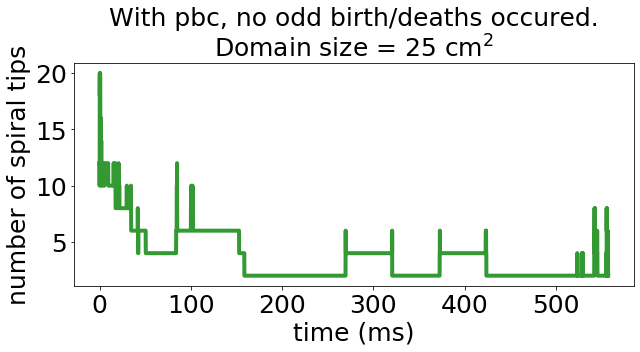

In [380]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(t_values, n_values, c='g', alpha=0.8, lw=4)
# ax.scatter(x=todd_b_values, y=nodd_b_values, label=f"odd births", c='b', s=100)
# ax.scatter(x=todd_d_values, y=nodd_d_values, label=f"odd deaths", c='r', s=100)
fontsize= 25
# ax.legend(fontsize=fontsize-5)
ax.set_xlabel('time (ms)', fontsize=fontsize)
ax.set_ylabel('number of spiral tips', fontsize=fontsize)
ax.tick_params(axis='both', labelsize= fontsize)
ax.set_title(f'With pbc, no odd birth/deaths occured.\nDomain size = {ds**2} cm$^2$',
            fontsize=fontsize)
plt.tight_layout()
fig.savefig(f"{nb_dir}/Figures/zero_odd_births-deaths_{descrip}.png",dpi=400)

In [381]:
# sum(n_series.isnull())
# set(n_series.values)
# dn_series

In [382]:
n_series = df.groupby('t').n.mean()
odd_array = n_series.values%2
num_odd_frames = np.add.reduce(odd_array)
print(f"the number of frames observed with an odd number of tips = {num_odd_frames}.")

the number of frames observed with an odd number of tips = 0.


In [383]:
# odd_frames = n_series[odd_array==1].index.values
# print(f"the first frame of odd tips was at t = {np.min(odd_frames)}.")
# print(f"the last frame of odd tips was at t = {np.max(odd_frames)}.")

In [384]:
dn_series = n_series.diff().dropna()  #this line needs changed if you want to know when the sampled rate occured
dn_series = dn_series[dn_series!=0].reset_index()
dn_series['W'] = 1/dn_series['t'].diff() #sampled birth/death rate - per milliseconds
dn_series = dn_series.dropna().rename(columns={'n':'dn'}).drop(columns='t')
dn_series['n'] = df['n']

In [385]:
df2 = pd.DataFrame(n_series).reset_index()
df2['dn'] = df2.n.diff()
df2 = df2[df2.dn!=0].dropna().copy()
df2['dt'] = df2.t.diff()
df2['W'] = 1/df2.dt.values
df2 = df2.dropna()
# dn_series = dn_series[dn_series!=0].reset_index()
# dn_series['W'] = 1/dn_series['t'].diff() #sampled birth/death rate - per milliseconds
# dn_series = dn_series.dropna().rename(columns={'n':'dn'}).drop(columns='t')


In [386]:
dn_values = dn_series['dn'].values
dn_bins = sorted(set(dn_values))
dn_bins.sort()
list_W_n = dn_bins
print(f"birth/death changes were consisted of {list_W_n}.")
xticks = [-6.0, -4.0, -2.0, 0, 2.0, 4.0, 6., 8.0]

# dn_bins =  [-6.5, -5.5, -4.5,-3.5, -2.5,-1.5, 0, 1.5,2.5, 3.5,4.5,5.5, 6.5,7.5, 8.5]
# dn_bins =  [-16.5, -15.5, -8.5,-7.5, 0,  7.5,8.5,15.5, 16.5]

a = np.array(dn_bins)-0.5
b = np.array(dn_bins)+0.5
c = np.empty((a.size + b.size,), dtype=a.dtype)
c[0::2] = a
c[1::2] = b
dn_bins = sorted(c)
print(dn_bins)
del a,b,c

birth/death changes were consisted of [-2.0, 2.0, 4.0].
[-2.5, -1.5, 1.5, 2.5, 3.5, 4.5]


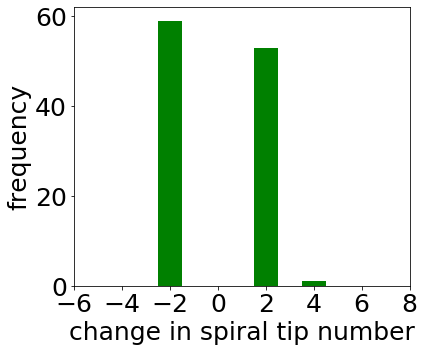

In [387]:

fig, ax = plt.subplots(figsize=(6,5))
# ax.hist(dn_values,    color='g', label='even')

ax.hist(dn_values,  bins=dn_bins,    color='g', label='even')

# ax.hist(dn_odd_births, bins = bins_odd, color='b', label='odd births')
# ax.hist(dn_odd_deaths, bins = bins_odd, color='r', label='odd deaths')
# ax.set_xticks([-16,-8,8,16])


# ax.legend(fontsize=fontsize-5)
ax.set_xticks(xticks)
# ax.set_yticks([0,10,20,30,40,50])
ax.tick_params(axis='both', labelsize= fontsize)
ax.set_ylabel('frequency', fontsize=fontsize)
ax.set_xlabel('change in spiral tip number', fontsize=fontsize)
plt.tight_layout()
fig.savefig(f"{nb_dir}/Figures/histogram_zero_odd_births-deaths_{descrip}.png",dpi=400)

# fig.savefig('Figures/histogram_zero_odd_births-deaths_ds_5_pbc.pdf')
# fig.savefig(f'Figures/histogram_zero_odd_births-deaths_ds_{ds}_pbc.png',dpi=400)
# fig.savefig(f'Figures/histogram_zero_odd_births-deaths_ds_{ds}_pbc.png',dpi=400)

In [388]:
# dn_values
# dn_series.query('dn==-2')

In [389]:
print(list_W_n)


[-2.0, 2.0, 4.0]


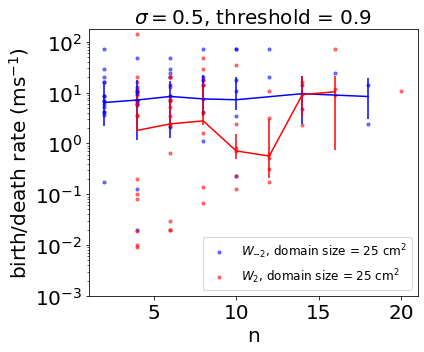

In [392]:
fontsize=20
dn_list = [-2,2]#list_W_n#
color_list = ['blue', 'red']#,'green']
assert(len(dn_list)==len(color_list))

# plot birth death rates with IQR y error bars with n on the x axis
fig, ax = plt.subplots(figsize=(6,5))
for dn, color in zip(dn_list,color_list):
    df2g = df2.query('W < 20').groupby(by=['dn','n']).W.describe()
    x_values, y_values, y_err_1, y_err_2 = df2g.loc[dn].dropna().reset_index()[['n', '50%','25%','75%']].values.T
    x_scatter_values, y_scatter_values = df2.query(f'dn=={dn}')[['n','W']].values.T
    yerr = np.array(list(zip(y_err_1,y_err_2))).T


    ax.scatter(x=x_scatter_values,y=y_scatter_values, c=color, s=10,alpha=0.5, label=f'$W_{{{int(dn)}}}$, domain size = {int(ds**2)} cm$^2$')
    ax.errorbar(x_values, y_values, yerr=yerr, c=color)

# ax.set_xticks(xticks)
# ax.set_yticks([0,10,20,30,40,50])
ymin, ymax = ax.get_ylim()
ax.set_ylim((1e-3,ymax+25))

ax.legend(loc='lower right', fontsize= fontsize-8)
ax.tick_params(axis='both', labelsize= fontsize)
ax.set_ylabel('birth/death rate (ms$^{-1}$)', fontsize=fontsize)
ax.set_xlabel('n', fontsize=fontsize) 
ax.set_yscale('log')
ax.set_title(f'$\sigma = {sigma}$, threshold = {threshold}', fontsize=fontsize)

# ax.set_title('high frequency birth deaths observed', fontsize=fontsize)
# ax.axis([20,60,0,7])
plt.tight_layout()
fig.savefig(f"{nb_dir}/Figures/birth_deaths_zero_odd_births-deaths_{descrip}.png",dpi=400)

# fig.savefig('Figures/birth_deaths_zero_odd_births-deaths_ds_5_pbc.pdf')
# fig.savefig(f'Figures/birth_deaths_zero_odd_births-deaths_ds_{ds}_pbc.png',dpi=400)